In [1]:
from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

In [2]:
def objective(params, pipeline,  X_train, y_train):
    """
        Кросс-валидация с текущими гиперпараметрами 
    :param params: гиперпараметры
    :pipeline: модель
    :X_train: матрица признаков
    :y_train: вектор целевой переменной
    :return: средняя точность на кросс-валидации
    """ 
                  
    # задаём модели требуемые параметры    
    pipeline.set_params(**params)
    
    # задаём параметры кросс-валидации (стратифицированная 4-фолдовая с перемешиванием)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
    
    # проводим кросс-валидацию  
    score = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1)
    
    # возвращаем результаты, которые записываются в Trials()
    return   {'loss': 1-score.mean(), 'params': params, 'status': STATUS_OK} 


def df_results(hp_results):
    """
        Отображаем результаты hyperopt в DataFrame  
    :hp_results: результаты hyperop
    :return: pandas DataFrame
    """ 
    
    results = pd.DataFrame([{**x, **x['params']} for x in  hp_results])
    results['scoring'] = 1 - results['loss']
    results.drop(['loss', 'status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['scoring'], ascending=False, inplace=True)
    return results

In [3]:
# загружаем данные
df = pd.read_csv('adult.data.csv')

# удаляем дубликаты
df.drop_duplicates(inplace=True, ignore_index=True)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
# готовим признаки и целевую переменную 
X = df.drop(['salary', 'native-country'], axis=1).copy()
y = df['salary'].map({'<=50K':0,'>50K':1}).values

# выбираем категориальные (тип object)
# и численные признаки (остальные типы)
num_columns = np.where(X.dtypes != 'object')[0]
cat_columns = np.where(X.dtypes == 'object')[0]

# пайплайн для категориальных признаков
cat_pipe = Pipeline([('imputer', SimpleImputer(missing_values='?', strategy='most_frequent')),
                     ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])

# пайплайн для численных признаков
num_pipe = Pipeline([('scaler', StandardScaler())])
    
# соединяем пайплайны вместе
transformer = ColumnTransformer(
                           transformers=[('cat', cat_pipe, cat_columns),
                                         ('num', num_pipe, num_columns)], 
                                         remainder='passthrough') 
# итоговая модель
model = Pipeline([('transformer', transformer),
                  ('lr', LogisticRegression(random_state=1, n_jobs=-1, solver='liblinear'))])

In [5]:
# задаём пространство поиска 
space = {
          'lr__penalty' : hp.choice('penalty', ['l1', 'l2']),
          'lr__C' : hp.loguniform('C', low=-4*np.log(10), high=2*np.log(10))
        }

# запускаем hyperopt
trials = Trials()
best = fmin( 
          # функция для оптимизации  
            partial(objective, pipeline=model, X_train=X, y_train=y),
          # пространство поиска гиперпараметров  
            space,
          # алгоритм поиска
            algo=tpe.suggest,
          # число итераций 
          # (можно ещё указать время поиска) 
            max_evals=20,
          # куда сохранять историю поиска
            trials=trials,
          # random state
            rstate=np.random.RandomState(1),
          # progressbar
            show_progressbar=True
        )

100%|███████████████████████████████████████████████| 20/20 [01:15<00:00,  3.77s/trial, best loss: 0.09461238871754352]


In [6]:
# выведем результаты
results = df_results(trials.results)
results.head()

,lr__C,lr__penalty,scoring
3,3.246672,l1,0.905388
6,21.024956,l2,0.905387
11,1.044878,l2,0.905364
0,51.113934,l1,0.905341
10,0.446510,l2,0.905337


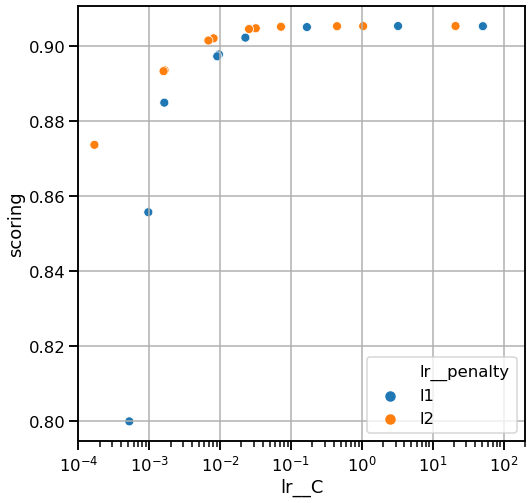

In [7]:
sns.set_context("talk")
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='lr__C', y='scoring', hue='lr__penalty', data=results);
ax.set_xscale('log')
ax.set_xlim(1e-4, 2e2)
ax.grid()